<a href="https://colab.research.google.com/github/JunSeokCheon/dacon_sign_language_classification/blob/master/model_fit%26predict.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
cd /content/drive/MyDrive/kaggle_study/sign_Languague

/content/drive/MyDrive/kaggle_study/sign_Languague


In [3]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import PIL
from tqdm.notebook import tqdm

from glob import glob
from google.colab import drive

In [4]:
agumeted_train = np.load('agumeted_train.npy')
agumeted_val = np.load('agumeted_val.npy')
agumeted_train_y = np.load('agumeted_train_y.npy')
agumeted_val_y = np.load('agumeted_val_y.npy')
X_test = np.load("X_test.npy")
submission = pd.read_csv('data/sample_submission.csv')

In [5]:
from tensorflow.keras import layers

IMG_SIZE = 128

data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMG_SIZE, IMG_SIZE), 
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.experimental.preprocessing.RandomFlip("horizontal"),
  layers.experimental.preprocessing.RandomRotation(0.2),
  layers.experimental.preprocessing.RandomZoom(0.3),
  # layers.Normalization(axis=-1, mean=None, variance=None)
])

resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMG_SIZE, IMG_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
  # layers.Normalization(axis=-1, mean=None, variance=None)
])

In [6]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, GlobalAveragePooling2D, Conv2D, MaxPool2D, ZeroPadding2D, BatchNormalization, Input, DepthwiseConv2D, Add, LeakyReLU, ReLU
from tensorflow.keras.optimizers import Adam, SGD

# VGG16 / epochs - 50 / 제출 점수 : 0.934

In [7]:
from tensorflow.keras.applications import VGG16

vgg_base = VGG16(weights=None, include_top = False, input_shape=(128,128,3))

def vgg16_build_model():
  model = Sequential()
  model.add(vgg_base)

  model.add(Flatten())

  model.add(Dense(128,activation="relu",kernel_initializer='he_normal'))
  model.add(BatchNormalization())
  model.add(Dropout(0.5))

  model.add(Dense(32,activation="relu",kernel_initializer='he_normal'))
  model.add(BatchNormalization())
  model.add(Dropout(0.5))

  model.add(Dense(11, activation="softmax"))
  model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
  
  return model

vgg_model = vgg16_build_model()
vgg_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dense (Dense)               (None, 128)               1048704   
                                                                 
 batch_normalization (BatchN  (None, 128)              512       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 32)                4128      
                                                      

In [ ]:
filepath= "saved/best_vgg16.hdf5"

callbacks = [
            #  tf.keras.callbacks.EarlyStopping(patience=5, monitor='val_loss'),
             tf.keras.callbacks.TensorBoard(log_dir='./logs', histogram_freq=1),
             tf.keras.callbacks.ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
             ]
      
history = vgg_model.fit(agumeted_train, agumeted_train_y,
          batch_size=32,
          epochs=50,
          validation_data=(agumeted_val,agumeted_val_y),
          callbacks=callbacks
          )

history_dict = history.history
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(loss)+1)
fig = plt.figure(figsize=(12,5))

ax1 = fig.add_subplot(1, 2, 1)
ax1.plot(epochs, loss, color='blue', label='train_loss')
ax1.plot(epochs, val_loss, color='red', label='val_loss')
ax1.set_title('Train and Validation Loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.grid()
ax1.legend()

accuracy = history_dict['accuracy']
val_accuracy = history_dict['val_accuracy']

ax2 = fig.add_subplot(1, 2, 2)
ax2.plot(epochs, accuracy, color='blue', label='accuracy')
ax2.plot(epochs, val_accuracy, color='red', label='val_accuracy')
ax2.set_title('Train and Validation Accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.grid()
ax2.legend()

plt.show()

vgg_model.load_weights("saved/best_vgg16.hdf5")
vgg_model.evaluate(agumeted_val, agumeted_val_y)

test_re = resize_and_rescale(X_test)
preds = vgg_model.predict(test_re)

submission['label'] = np.argmax(preds, axis=1)
submission['label'][submission['label'] == 10] = '10-1' ## label : 10 -> '10-1'
submission['label'][submission['label'] == 0] = '10-2' ## Label : 0 -> '10-2'
submission['label'] = submission['label'].apply(lambda x : str(x)) ## Dtype : int -> object

submission.to_csv('./keras_vgg16_epoch50.csv', index=False) 

# InceptionResNetV2 / epochs - 50 / 제출 점수 : 0.906

In [8]:
from tensorflow.keras.applications import InceptionResNetV2

InceptionResNetV2_base = InceptionResNetV2(weights= None, include_top = False, input_shape=(128,128,3))

In [9]:
def InceptionResNetV2_build_model():
  model = Sequential()
  model.add(InceptionResNetV2_base)

  model.add(Flatten())

  model.add(Dense(128,activation="relu",kernel_initializer='he_normal'))
  model.add(BatchNormalization())
  model.add(Dropout(0.5))

  model.add(Dense(32,activation="relu",kernel_initializer='he_normal'))
  model.add(BatchNormalization())
  model.add(Dropout(0.5))

  model.add(Dense(11, activation="softmax"))
  model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
  
  return model

InceptionResNetV2_model = InceptionResNetV2_build_model()
InceptionResNetV2_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_resnet_v2 (Functi  (None, 2, 2, 1536)       54336736  
 onal)                                                           
                                                                 
 flatten_1 (Flatten)         (None, 6144)              0         
                                                                 
 dense_3 (Dense)             (None, 128)               786560    
                                                                 
 batch_normalization_205 (Ba  (None, 128)              512       
 tchNormalization)                                               
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 dense_4 (Dense)             (None, 32)               

In [9]:
filepath= "saved/best_InceptionResNetV2.hdf5"

callbacks = [
            #  tf.keras.callbacks.EarlyStopping(patience=5, monitor='val_loss'),
             tf.keras.callbacks.TensorBoard(log_dir='./logs', histogram_freq=1),
             tf.keras.callbacks.ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
             ]

             
history = InceptionResNetV2_model.fit(agumeted_train, agumeted_train_y,
          batch_size=32,
          epochs=50,
          validation_data=(agumeted_val,agumeted_val_y),
          callbacks=callbacks
          )

Epoch 1/50
558/558 [==============================] - ETA: 0s - loss: 2.2683 - accuracy: 0.2564
Epoch 1: val_loss improved from inf to 2.65444, saving model to saved/best_InceptionResNetV2.hdf5
558/558 [==============================] - 167s 241ms/step - loss: 2.2683 - accuracy: 0.2564 - val_loss: 2.6544 - val_accuracy: 0.2384
Epoch 2/50
558/558 [==============================] - ETA: 0s - loss: 1.2044 - accuracy: 0.5844
Epoch 2: val_loss improved from 2.65444 to 1.45268, saving model to saved/best_InceptionResNetV2.hdf5
558/558 [==============================] - 134s 239ms/step - loss: 1.2044 - accuracy: 0.5844 - val_loss: 1.4527 - val_accuracy: 0.5407
Epoch 3/50
558/558 [==============================] - ETA: 0s - loss: 0.8056 - accuracy: 0.7335
Epoch 3: val_loss improved from 1.45268 to 1.30363, saving model to saved/best_InceptionResNetV2.hdf5
558/558 [==============================] - 132s 237ms/step - loss: 0.8056 - accuracy: 0.7335 - val_loss: 1.3036 - val_accuracy: 0.5930
Epoch

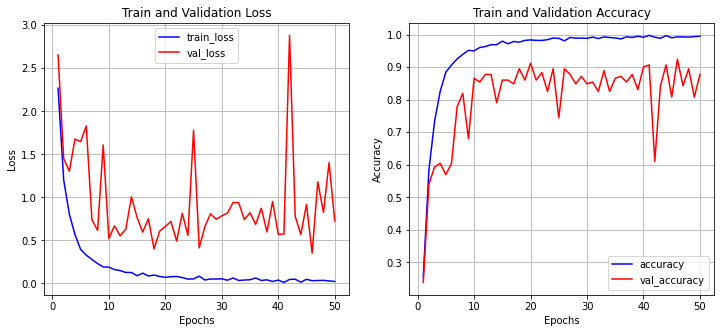

In [10]:
history_dict = history.history
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(loss)+1)
fig = plt.figure(figsize=(12,5))

ax1 = fig.add_subplot(1, 2, 1)
ax1.plot(epochs, loss, color='blue', label='train_loss')
ax1.plot(epochs, val_loss, color='red', label='val_loss')
ax1.set_title('Train and Validation Loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.grid()
ax1.legend()

accuracy = history_dict['accuracy']
val_accuracy = history_dict['val_accuracy']

ax2 = fig.add_subplot(1, 2, 2)
ax2.plot(epochs, accuracy, color='blue', label='accuracy')
ax2.plot(epochs, val_accuracy, color='red', label='val_accuracy')
ax2.set_title('Train and Validation Accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.grid()
ax2.legend()

plt.show()

In [11]:
InceptionResNetV2_model.load_weights("saved/best_InceptionResNetV2.hdf5")
InceptionResNetV2_model.evaluate(agumeted_val, agumeted_val_y)

6/6 [==============================] - 0s 70ms/step - loss: 0.3523 - accuracy: 0.9244


[0.35231584310531616, 0.9244186282157898]

In [12]:
test_re = resize_and_rescale(X_test)
preds = InceptionResNetV2_model.predict(test_re)

submission['label'] = np.argmax(preds, axis=1)
submission['label'][submission['label'] == 10] = '10-1' ## label : 10 -> '10-1'
submission['label'][submission['label'] == 0] = '10-2' ## Label : 0 -> '10-2'
submission['label'] = submission['label'].apply(lambda x : str(x)) ## Dtype : int -> object

submission.to_csv('./keras_InceptionResNetV2_epoch50.csv', index=False) 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


# EfficientNetB4 / epochs - 50 / 제출 점수 : 0.915

In [10]:
from tensorflow.keras.applications import EfficientNetB4

EfficientNetB4_base = EfficientNetB4(weights= None, include_top = False, input_shape=(128,128,3))

In [11]:
def EfficientNetB4_build_model():
  model = Sequential()
  model.add(EfficientNetB4_base)

  model.add(Flatten())

  model.add(Dense(128,activation="relu",kernel_initializer='he_normal'))
  model.add(BatchNormalization())
  model.add(Dropout(0.5))

  model.add(Dense(32,activation="relu",kernel_initializer='he_normal'))
  model.add(BatchNormalization())
  model.add(Dropout(0.5))

  model.add(Dense(11, activation="softmax"))
  model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
  
  return model

EfficientNetB4_model = EfficientNetB4_build_model()
EfficientNetB4_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb4 (Functional)  (None, 4, 4, 1792)       17673823  
                                                                 
 flatten_2 (Flatten)         (None, 28672)             0         
                                                                 
 dense_6 (Dense)             (None, 128)               3670144   
                                                                 
 batch_normalization_207 (Ba  (None, 128)              512       
 tchNormalization)                                               
                                                                 
 dropout_4 (Dropout)         (None, 128)               0         
                                                                 
 dense_7 (Dense)             (None, 32)                4128      
                                                      

In [9]:
filepath= "saved/best_efficientNetB4.hdf5"

callbacks = [
            #  tf.keras.callbacks.EarlyStopping(patience=5, monitor='val_loss'),
             tf.keras.callbacks.TensorBoard(log_dir='./logs', histogram_freq=1),
             tf.keras.callbacks.ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
             ]

             
history = EfficientNetB4_model.fit(agumeted_train, agumeted_train_y,
          batch_size=32,
          epochs=50,
          validation_data=(agumeted_val,agumeted_val_y),
          callbacks=callbacks
          )

Epoch 1/50
558/558 [==============================] - ETA: 0s - loss: 2.7649 - accuracy: 0.0949
Epoch 1: val_loss improved from inf to 2.43135, saving model to saved/best_efficientNetB4.hdf5
558/558 [==============================] - 153s 213ms/step - loss: 2.7649 - accuracy: 0.0949 - val_loss: 2.4314 - val_accuracy: 0.0756
Epoch 2/50
558/558 [==============================] - ETA: 0s - loss: 2.5029 - accuracy: 0.0978
Epoch 2: val_loss improved from 2.43135 to 2.42935, saving model to saved/best_efficientNetB4.hdf5
558/558 [==============================] - 115s 207ms/step - loss: 2.5029 - accuracy: 0.0978 - val_loss: 2.4293 - val_accuracy: 0.0872
Epoch 3/50
558/558 [==============================] - ETA: 0s - loss: 2.4309 - accuracy: 0.1070
Epoch 3: val_loss improved from 2.42935 to 2.35044, saving model to saved/best_efficientNetB4.hdf5
558/558 [==============================] - 115s 207ms/step - loss: 2.4309 - accuracy: 0.1070 - val_loss: 2.3504 - val_accuracy: 0.1163
Epoch 4/50
558

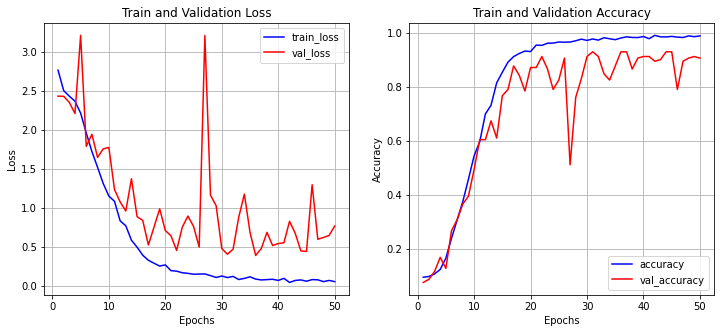

In [10]:
history_dict = history.history
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(loss)+1)
fig = plt.figure(figsize=(12,5))

ax1 = fig.add_subplot(1, 2, 1)
ax1.plot(epochs, loss, color='blue', label='train_loss')
ax1.plot(epochs, val_loss, color='red', label='val_loss')
ax1.set_title('Train and Validation Loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.grid()
ax1.legend()

accuracy = history_dict['accuracy']
val_accuracy = history_dict['val_accuracy']

ax2 = fig.add_subplot(1, 2, 2)
ax2.plot(epochs, accuracy, color='blue', label='accuracy')
ax2.plot(epochs, val_accuracy, color='red', label='val_accuracy')
ax2.set_title('Train and Validation Accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.grid()
ax2.legend()

plt.show()

In [11]:
EfficientNetB4_model.load_weights("saved/best_efficientNetB4.hdf5")
EfficientNetB4_model.evaluate(agumeted_val, agumeted_val_y)

6/6 [==============================] - 0s 43ms/step - loss: 0.3860 - accuracy: 0.9302


[0.3860405385494232, 0.930232584476471]

In [12]:
test_re = resize_and_rescale(X_test)
preds = EfficientNetB4_model.predict(test_re)

submission['label'] = np.argmax(preds, axis=1)
submission['label'][submission['label'] == 10] = '10-1' ## label : 10 -> '10-1'
submission['label'][submission['label'] == 0] = '10-2' ## Label : 0 -> '10-2'
submission['label'] = submission['label'].apply(lambda x : str(x)) ## Dtype : int -> object

submission.to_csv('./keras_efficientNetB4_epoch50.csv', index=False) 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


# EfficientNetV2S / epochs - 50 / 제출 점수 : 0.86

In [7]:
from tensorflow.keras.applications import EfficientNetV2S

EfficientNetV2S_base = EfficientNetV2S(weights= None, include_top = False, input_shape=(128,128,3), include_preprocessing=False)

In [8]:
def EfficientNetV2S_build_model():
  model = Sequential()
  model.add(EfficientNetV2S_base)

  model.add(Flatten())

  model.add(Dense(128,activation="relu",kernel_initializer='he_normal'))
  model.add(BatchNormalization())
  model.add(Dropout(0.5))

  model.add(Dense(32,activation="relu",kernel_initializer='he_normal'))
  model.add(BatchNormalization())
  model.add(Dropout(0.5))

  model.add(Dense(11, activation="softmax"))

  # sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
  model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
  
  return model

EfficientNetV2S_model = EfficientNetV2S_build_model()
EfficientNetV2S_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetv2-s (Functiona  (None, 4, 4, 1280)       20331360  
 l)                                                              
                                                                 
 flatten (Flatten)           (None, 20480)             0         
                                                                 
 dense (Dense)               (None, 128)               2621568   
                                                                 
 batch_normalization (BatchN  (None, 128)              512       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 32)               

In [9]:
filepath= "saved/best_EfficientNetV2S.hdf5"

callbacks = [
            #  tf.keras.callbacks.EarlyStopping(patience=5, monitor='val_loss'),
             tf.keras.callbacks.TensorBoard(log_dir='./logs', histogram_freq=1),
             tf.keras.callbacks.ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
             ]

             
history = EfficientNetV2S_model.fit(agumeted_train, agumeted_train_y,
          batch_size=32,
          epochs=50,
          validation_data=(agumeted_val,agumeted_val_y),
          callbacks=callbacks
          )

Epoch 1/50
558/558 [==============================] - ETA: 0s - loss: 2.7153 - accuracy: 0.1263
Epoch 1: val_loss improved from inf to 2.16854, saving model to saved/best_EfficientNetV2S.hdf5
558/558 [==============================] - 122s 155ms/step - loss: 2.7153 - accuracy: 0.1263 - val_loss: 2.1685 - val_accuracy: 0.2093
Epoch 2/50
558/558 [==============================] - ETA: 0s - loss: 2.2204 - accuracy: 0.2052
Epoch 2: val_loss improved from 2.16854 to 1.96272, saving model to saved/best_EfficientNetV2S.hdf5
558/558 [==============================] - 85s 153ms/step - loss: 2.2204 - accuracy: 0.2052 - val_loss: 1.9627 - val_accuracy: 0.2558
Epoch 3/50
558/558 [==============================] - ETA: 0s - loss: 1.7967 - accuracy: 0.3283
Epoch 3: val_loss improved from 1.96272 to 1.69278, saving model to saved/best_EfficientNetV2S.hdf5
558/558 [==============================] - 85s 152ms/step - loss: 1.7967 - accuracy: 0.3283 - val_loss: 1.6928 - val_accuracy: 0.3953
Epoch 4/50
55

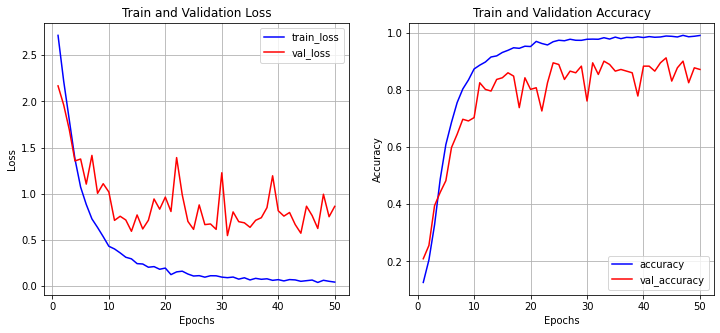

In [10]:
history_dict = history.history
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(loss)+1)
fig = plt.figure(figsize=(12,5))

ax1 = fig.add_subplot(1, 2, 1)
ax1.plot(epochs, loss, color='blue', label='train_loss')
ax1.plot(epochs, val_loss, color='red', label='val_loss')
ax1.set_title('Train and Validation Loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.grid()
ax1.legend()

accuracy = history_dict['accuracy']
val_accuracy = history_dict['val_accuracy']

ax2 = fig.add_subplot(1, 2, 2)
ax2.plot(epochs, accuracy, color='blue', label='accuracy')
ax2.plot(epochs, val_accuracy, color='red', label='val_accuracy')
ax2.set_title('Train and Validation Accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.grid()
ax2.legend()

plt.show()

In [11]:
EfficientNetV2S_model.load_weights("saved/best_EfficientNetV2S.hdf5")
EfficientNetV2S_model.evaluate(agumeted_val, agumeted_val_y)

6/6 [==============================] - 0s 44ms/step - loss: 0.5481 - accuracy: 0.8953


[0.5481221079826355, 0.895348846912384]

In [12]:
test_re = resize_and_rescale(X_test)
preds = EfficientNetV2S_model.predict(test_re)

submission['label'] = np.argmax(preds, axis=1)
submission['label'][submission['label'] == 10] = '10-1' ## label : 10 -> '10-1'
submission['label'][submission['label'] == 0] = '10-2' ## Label : 0 -> '10-2'
submission['label'] = submission['label'].apply(lambda x : str(x)) ## Dtype : int -> object

submission.to_csv('./keras_EfficientNetV2S_epoch50.csv', index=False) 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


# ensemble / epochs - 50 / 제출 점수 : 0.897

In [12]:
models = [vgg_model, InceptionResNetV2_model, EfficientNetB4_model]
model_input = tf.keras.Input(shape=(128, 128, 3))
model_outputs = [model(model_input) for model in models]
ensemble_output = tf.keras.layers.Average()(model_outputs)
ensemble_model = tf.keras.Model(inputs=model_input, outputs=ensemble_output)

In [13]:
ensemble_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 sequential_2 (Sequential)      (None, 11)           15768523    ['input_4[0][0]']                
                                                                                                  
 sequential_3 (Sequential)      (None, 11)           55128427    ['input_4[0][0]']                
                                                                                                  
 sequential_4 (Sequential)      (None, 11)           21349098    ['input_4[0][0]']            

In [17]:
ensemble_model.compile(optimizer='adam',
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy'])

In [18]:
filepath= "saved/best_ensemble.hdf5"

callbacks = [
            #  tf.keras.callbacks.EarlyStopping(patience=5, monitor='val_loss'),
             tf.keras.callbacks.TensorBoard(log_dir='./logs', histogram_freq=1),
             tf.keras.callbacks.ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
             ]

             
history = ensemble_model.fit(agumeted_train, agumeted_train_y,
          batch_size=32,
          epochs=50,
          validation_data=(agumeted_val,agumeted_val_y),
          callbacks=callbacks
          )

Epoch 1/50
558/558 [==============================] - ETA: 0s - loss: 2.2838 - accuracy: 0.2211
Epoch 1: val_loss improved from inf to 2.54587, saving model to saved/best_ensemble.hdf5
558/558 [==============================] - 309s 464ms/step - loss: 2.2838 - accuracy: 0.2211 - val_loss: 2.5459 - val_accuracy: 0.1512
Epoch 2/50
558/558 [==============================] - ETA: 0s - loss: 1.8258 - accuracy: 0.4269
Epoch 2: val_loss improved from 2.54587 to 2.33297, saving model to saved/best_ensemble.hdf5
558/558 [==============================] - 257s 461ms/step - loss: 1.8258 - accuracy: 0.4269 - val_loss: 2.3330 - val_accuracy: 0.1977
Epoch 3/50
558/558 [==============================] - ETA: 0s - loss: 1.5521 - accuracy: 0.5792
Epoch 3: val_loss improved from 2.33297 to 1.85812, saving model to saved/best_ensemble.hdf5
558/558 [==============================] - 261s 468ms/step - loss: 1.5521 - accuracy: 0.5792 - val_loss: 1.8581 - val_accuracy: 0.4709
Epoch 4/50
558/558 [============

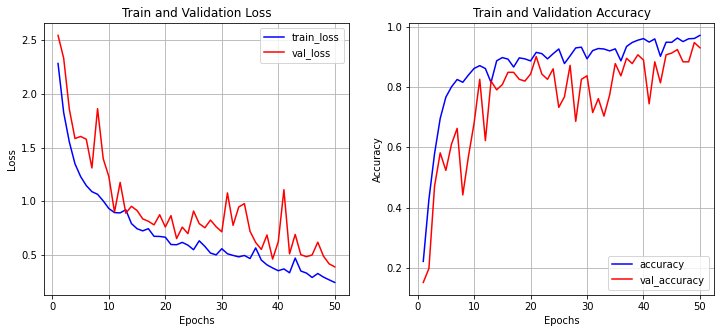

In [19]:
history_dict = history.history
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(loss)+1)
fig = plt.figure(figsize=(12,5))

ax1 = fig.add_subplot(1, 2, 1)
ax1.plot(epochs, loss, color='blue', label='train_loss')
ax1.plot(epochs, val_loss, color='red', label='val_loss')
ax1.set_title('Train and Validation Loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.grid()
ax1.legend()

accuracy = history_dict['accuracy']
val_accuracy = history_dict['val_accuracy']

ax2 = fig.add_subplot(1, 2, 2)
ax2.plot(epochs, accuracy, color='blue', label='accuracy')
ax2.plot(epochs, val_accuracy, color='red', label='val_accuracy')
ax2.set_title('Train and Validation Accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.grid()
ax2.legend()

plt.show()

In [20]:
ensemble_model.load_weights("saved/best_ensemble.hdf5")
ensemble_model.evaluate(agumeted_val, agumeted_val_y)

6/6 [==============================] - 1s 114ms/step - loss: 0.3878 - accuracy: 0.9302


[0.387781023979187, 0.930232584476471]

In [21]:
test_re = resize_and_rescale(X_test)
preds = ensemble_model.predict(test_re)

submission['label'] = np.argmax(preds, axis=1)
submission['label'][submission['label'] == 10] = '10-1' ## label : 10 -> '10-1'
submission['label'][submission['label'] == 0] = '10-2' ## Label : 0 -> '10-2'
submission['label'] = submission['label'].apply(lambda x : str(x)) ## Dtype : int -> object

submission.to_csv('./keras_ensemble_epoch50.csv', index=False) 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


# ensemble / epochs - 100 / 제출 점수 : 0.906

In [14]:
models = [vgg_model, InceptionResNetV2_model, EfficientNetB4_model]
model_input = tf.keras.Input(shape=(128, 128, 3))
model_outputs = [model(model_input) for model in models]
ensemble_output = tf.keras.layers.Average()(model_outputs)
ensemble_model = tf.keras.Model(inputs=model_input, outputs=ensemble_output)

In [15]:
ensemble_model.compile(optimizer='adam',
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy'])

In [16]:
filepath= "saved/best_ensemble_epoch100.hdf5"

callbacks = [
            #  tf.keras.callbacks.EarlyStopping(patience=5, monitor='val_loss'),
             tf.keras.callbacks.TensorBoard(log_dir='./logs', histogram_freq=1),
             tf.keras.callbacks.ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
             ]

             
history = ensemble_model.fit(agumeted_train, agumeted_train_y,
          batch_size=32,
          epochs=100,
          validation_data=(agumeted_val,agumeted_val_y),
          callbacks=callbacks
          )

Epoch 1/100
558/558 [==============================] - ETA: 0s - loss: 2.3670 - accuracy: 0.1857
Epoch 1: val_loss improved from inf to 2.95828, saving model to saved/best_ensemble_epoch100.hdf5
558/558 [==============================] - 336s 489ms/step - loss: 2.3670 - accuracy: 0.1857 - val_loss: 2.9583 - val_accuracy: 0.1105
Epoch 2/100
558/558 [==============================] - ETA: 0s - loss: 1.9383 - accuracy: 0.3535
Epoch 2: val_loss improved from 2.95828 to 2.26800, saving model to saved/best_ensemble_epoch100.hdf5
558/558 [==============================] - 266s 477ms/step - loss: 1.9383 - accuracy: 0.3535 - val_loss: 2.2680 - val_accuracy: 0.2093
Epoch 3/100
558/558 [==============================] - ETA: 0s - loss: 1.6675 - accuracy: 0.4812
Epoch 3: val_loss did not improve from 2.26800
558/558 [==============================] - 249s 447ms/step - loss: 1.6675 - accuracy: 0.4812 - val_loss: 2.7081 - val_accuracy: 0.1163
Epoch 4/100
558/558 [==============================] - ET

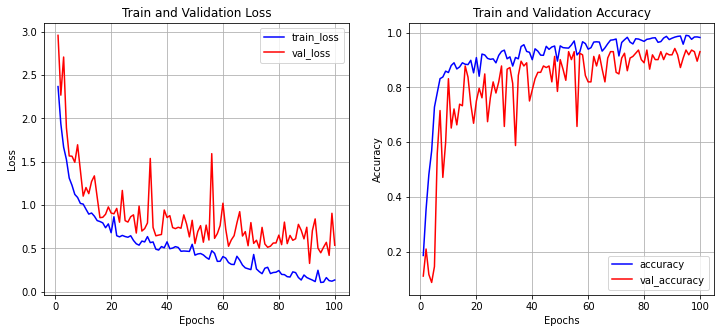

In [17]:
history_dict = history.history
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(loss)+1)
fig = plt.figure(figsize=(12,5))

ax1 = fig.add_subplot(1, 2, 1)
ax1.plot(epochs, loss, color='blue', label='train_loss')
ax1.plot(epochs, val_loss, color='red', label='val_loss')
ax1.set_title('Train and Validation Loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.grid()
ax1.legend()

accuracy = history_dict['accuracy']
val_accuracy = history_dict['val_accuracy']

ax2 = fig.add_subplot(1, 2, 2)
ax2.plot(epochs, accuracy, color='blue', label='accuracy')
ax2.plot(epochs, val_accuracy, color='red', label='val_accuracy')
ax2.set_title('Train and Validation Accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.grid()
ax2.legend()

plt.show()

In [18]:
ensemble_model.load_weights("saved/best_ensemble_epoch100.hdf5")
ensemble_model.evaluate(agumeted_val, agumeted_val_y)

6/6 [==============================] - 1s 118ms/step - loss: 0.3259 - accuracy: 0.9419


[0.3258618116378784, 0.9418604373931885]

In [19]:
test_re = resize_and_rescale(X_test)
preds = ensemble_model.predict(test_re)

submission['label'] = np.argmax(preds, axis=1)
submission['label'][submission['label'] == 10] = '10-1' ## label : 10 -> '10-1'
submission['label'][submission['label'] == 0] = '10-2' ## Label : 0 -> '10-2'
submission['label'] = submission['label'].apply(lambda x : str(x)) ## Dtype : int -> object

submission.to_csv('./keras_ensemble_epoch100.csv', index=False) 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


# ensemble (가중치 분배) / epochs - 100 / 제출 점수 : 
정확도 기대 못함

In [16]:
class WeightedAverageLayer(tf.keras.layers.Layer):
    def __init__(self, w1, w2, w3, **kwargs):
        super(WeightedAverageLayer, self).__init__(**kwargs)
        self.w1 = w1
        self.w2 = w2
        self.w3 = w3

    def get_config(self):
        config = super().get_config().copy()
        config.update({
            'w1': self.w1,
            'w2': self.w2,
            'w3': self.w3,
        })
        return config

    def call(self, inputs):
        return self.w1 * inputs[0] + self.w2 * inputs[1] + self.w3 * inputs[2]

In [17]:
models = [vgg_model, InceptionResNetV2_model, EfficientNetB4_model]
model_input = tf.keras.Input(shape=(128, 128, 3))
model_outputs = [model(model_input) for model in models]
ensemble_output = WeightedAverageLayer(0.45, 0.25, 0.3)(model_outputs)
ensemble_model = tf.keras.Model(inputs=model_input, outputs=ensemble_output)

In [18]:
ensemble_model.compile(optimizer='adam',
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy'])

In [ ]:
filepath= "saved/best_ensemble_epoch100_weightSplit.hdf5"

callbacks = [
            #  tf.keras.callbacks.EarlyStopping(patience=5, monitor='val_loss'),
             tf.keras.callbacks.TensorBoard(log_dir='./logs', histogram_freq=1),
             tf.keras.callbacks.ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
             ]

             
history = ensemble_model.fit(agumeted_train, agumeted_train_y,
          batch_size=32,
          epochs=100,
          validation_data=(agumeted_val,agumeted_val_y),
          callbacks=callbacks
          )

In [ ]:
history_dict = history.history
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(loss)+1)
fig = plt.figure(figsize=(12,5))

ax1 = fig.add_subplot(1, 2, 1)
ax1.plot(epochs, loss, color='blue', label='train_loss')
ax1.plot(epochs, val_loss, color='red', label='val_loss')
ax1.set_title('Train and Validation Loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.grid()
ax1.legend()

accuracy = history_dict['accuracy']
val_accuracy = history_dict['val_accuracy']

ax2 = fig.add_subplot(1, 2, 2)
ax2.plot(epochs, accuracy, color='blue', label='accuracy')
ax2.plot(epochs, val_accuracy, color='red', label='val_accuracy')
ax2.set_title('Train and Validation Accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.grid()
ax2.legend()

plt.show()

In [ ]:
ensemble_model.load_weights("saved/best_ensemble_epoch100_weightSplit.hdf5")
ensemble_model.evaluate(agumeted_val, agumeted_val_y)

In [ ]:
test_re = resize_and_rescale(X_test)
preds = ensemble_model.predict(test_re)

submission['label'] = np.argmax(preds, axis=1)
submission['label'][submission['label'] == 10] = '10-1' ## label : 10 -> '10-1'
submission['label'][submission['label'] == 0] = '10-2' ## Label : 0 -> '10-2'
submission['label'] = submission['label'].apply(lambda x : str(x)) ## Dtype : int -> object

submission.to_csv('./keras_ensemble_epoch100_weightSplit.csv', index=False) 

# Xception / epochs = 100 / 제출 점수 : 0.934

In [12]:
from tensorflow.keras.applications import Xception

Xception_base = Xception(weights=None, include_top = False, input_shape=(128,128,3))

In [13]:
def Xception_build_model():
  model = Sequential()
  model.add(Xception_base)

  model.add(Flatten())

  model.add(Dense(128,activation="relu",kernel_initializer='he_normal'))
  model.add(BatchNormalization())
  model.add(Dropout(0.5))

  model.add(Dense(32,activation="relu",kernel_initializer='he_normal'))
  model.add(BatchNormalization())
  model.add(Dropout(0.5))

  model.add(Dense(11, activation="softmax"))
  model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
  
  return model

Xception_model = Xception_build_model()
Xception_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 4, 4, 2048)        20861480  
                                                                 
 flatten_1 (Flatten)         (None, 32768)             0         
                                                                 
 dense_3 (Dense)             (None, 128)               4194432   
                                                                 
 batch_normalization_14 (Bat  (None, 128)              512       
 chNormalization)                                                
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 dense_4 (Dense)             (None, 32)                4128      
                                                      

In [14]:
filepath= "saved/best_Xception.hdf5"

callbacks = [
            #  tf.keras.callbacks.EarlyStopping(patience=5, monitor='val_loss'),
             tf.keras.callbacks.TensorBoard(log_dir='./logs', histogram_freq=1),
             tf.keras.callbacks.ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
             ]

             
history = Xception_model.fit(agumeted_train, agumeted_train_y,
          batch_size=32,
          epochs=100,
          validation_data=(agumeted_val,agumeted_val_y),
          callbacks=callbacks
          )

Epoch 1/100
558/558 [==============================] - ETA: 0s - loss: 2.3253 - accuracy: 0.2185
Epoch 1: val_loss improved from inf to 2.94246, saving model to saved/best_Xception.hdf5
558/558 [==============================] - 118s 202ms/step - loss: 2.3253 - accuracy: 0.2185 - val_loss: 2.9425 - val_accuracy: 0.0872
Epoch 2/100
558/558 [==============================] - ETA: 0s - loss: 1.3827 - accuracy: 0.4864
Epoch 2: val_loss improved from 2.94246 to 2.17723, saving model to saved/best_Xception.hdf5
558/558 [==============================] - 113s 202ms/step - loss: 1.3827 - accuracy: 0.4864 - val_loss: 2.1772 - val_accuracy: 0.3140
Epoch 3/100
558/558 [==============================] - ETA: 0s - loss: 0.9451 - accuracy: 0.6580
Epoch 3: val_loss improved from 2.17723 to 1.12516, saving model to saved/best_Xception.hdf5
558/558 [==============================] - 113s 202ms/step - loss: 0.9451 - accuracy: 0.6580 - val_loss: 1.1252 - val_accuracy: 0.6337
Epoch 4/100
558/558 [========

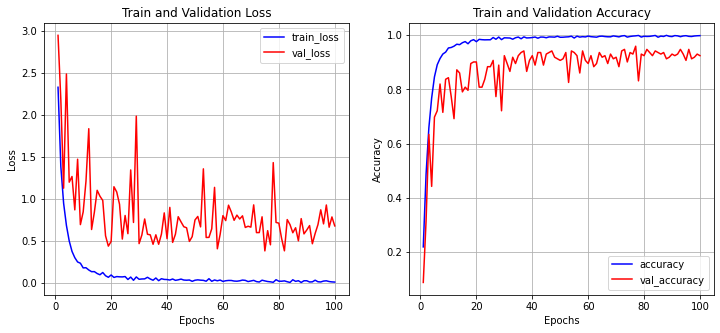

In [15]:
history_dict = history.history
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(loss)+1)
fig = plt.figure(figsize=(12,5))

ax1 = fig.add_subplot(1, 2, 1)
ax1.plot(epochs, loss, color='blue', label='train_loss')
ax1.plot(epochs, val_loss, color='red', label='val_loss')
ax1.set_title('Train and Validation Loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.grid()
ax1.legend()

accuracy = history_dict['accuracy']
val_accuracy = history_dict['val_accuracy']

ax2 = fig.add_subplot(1, 2, 2)
ax2.plot(epochs, accuracy, color='blue', label='accuracy')
ax2.plot(epochs, val_accuracy, color='red', label='val_accuracy')
ax2.set_title('Train and Validation Accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.grid()
ax2.legend()

plt.show()

In [16]:
Xception_model.load_weights("saved/best_Xception.hdf5")
Xception_model.evaluate(agumeted_val, agumeted_val_y)

6/6 [==============================] - 0s 49ms/step - loss: 0.3796 - accuracy: 0.9360


[0.37959226965904236, 0.9360465407371521]

In [17]:
test_re = resize_and_rescale(X_test)
preds = Xception_model.predict(test_re)

submission['label'] = np.argmax(preds, axis=1)
submission['label'][submission['label'] == 10] = '10-1' ## label : 10 -> '10-1'
submission['label'][submission['label'] == 0] = '10-2' ## Label : 0 -> '10-2'
submission['label'] = submission['label'].apply(lambda x : str(x)) ## Dtype : int -> object

submission.to_csv('./keras_Xception_epoch100_.csv', index=False) 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


# Resnet50